# Quantitative Finance Model using Donadio and Ghosh Learn Algorithmic Trading Chapter 2 APO & MACD Examples
### David Lowe
### August 3, 2022

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This script aims to replicate the APO and MACD examples found in chapter two of the book Learn Algorithmic Trading by Sebastien Donadio and Sourav Ghosh. The script seeks to validate the Python environment and package requirements for running these code examples successfully. The eventual goal is to integrate various example code segments from the book into an end-to-end algorithmic trading system.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Sharadar US Equities and Fund Prices from Quandl/Nasdaq Data Link

Source and Further Discussion of the Code Examples: https://github.com/PacktPublishing/Learn-Algorithmic-Trading

# Task 1 - Prepare Environment

## 1.a) Load the required packages and modules

In [1]:
# import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
# import statistics as stats
# import seaborn as sns

## 1.b) Set up the controlling parameters and functions

In [2]:
# Specify the key modeling parameters below
DATA_STORE = '../sharadar.h5'
ticker_symbol = 'GOOGL'

EMA_WINDOW_FAST = 10
EMA_WINDOW_SLOW = 40
EMA_WINDOW_MACD = 20

MODEL_START_DATE = date(2014, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2018, 12, 31)
print("Ending date for the model:", MODEL_END_DATE)

Starting date for the model: 2014-01-01
Ending date for the model: 2018-12-31


# Task 2 - Acquire and Pre-Process Data

## Instead of using pandas-datareader like in the book example, this script will use a home-grown data source.

In [3]:
with pd.HDFStore(DATA_STORE) as store:
    goog_data = (store['quandl/sharadar/sep'].loc[[ticker_symbol], ['open', 'high', 'low', 'closeadj', 'volume']])
goog_data.reset_index(level=0, inplace=True)
goog_data.sort_index(inplace=True)
goog_data = goog_data[MODEL_START_DATE:MODEL_END_DATE]
goog_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2014-01-02 to 2018-12-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ticker    1258 non-null   object 
 1   open      1258 non-null   float64
 2   high      1258 non-null   float64
 3   low       1258 non-null   float64
 4   closeadj  1258 non-null   float64
 5   volume    1258 non-null   float64
dtypes: float64(5), object(1)
memory usage: 68.8+ KB


# Task 3 - Build model with the APO indicator

## This code segment implements the absolute price oscillator, with the faster EMA using a period of 10 days and a slower EMA using a period of 40 days, and default smoothing factors being 2/11 and 2/41, respectively, for the two EMAs.

In [4]:
close = goog_data['closeadj']

K_fast = 2 / (EMA_WINDOW_FAST + 1) # smoothing factor for fast EMA
ema_fast = 0
K_slow = 2 / (EMA_WINDOW_SLOW + 1) # smoothing factor for slow EMA
ema_slow = 0

ema_fast_values = [] # we will hold fast EMA values for visualization purposes
ema_slow_values = [] # we will hold slow EMA values for visualization purposes
apo_values = [] # track computed absolute price oscillator values
for close_price in close:
  if ema_fast == 0: # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_fast + ema_fast
    ema_slow = (close_price - ema_slow) * K_slow + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)
  apo_values.append(ema_fast - ema_slow)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(AbsolutePriceOscillator=pd.Series(apo_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
apo = goog_data['AbsolutePriceOscillator']
print(apo.head())

date
2014-01-02    0.000000
2014-01-03   -0.027007
2014-01-06   -0.006810
2014-01-07    0.080676
2014-01-08    0.155898
Name: AbsolutePriceOscillator, dtype: float64


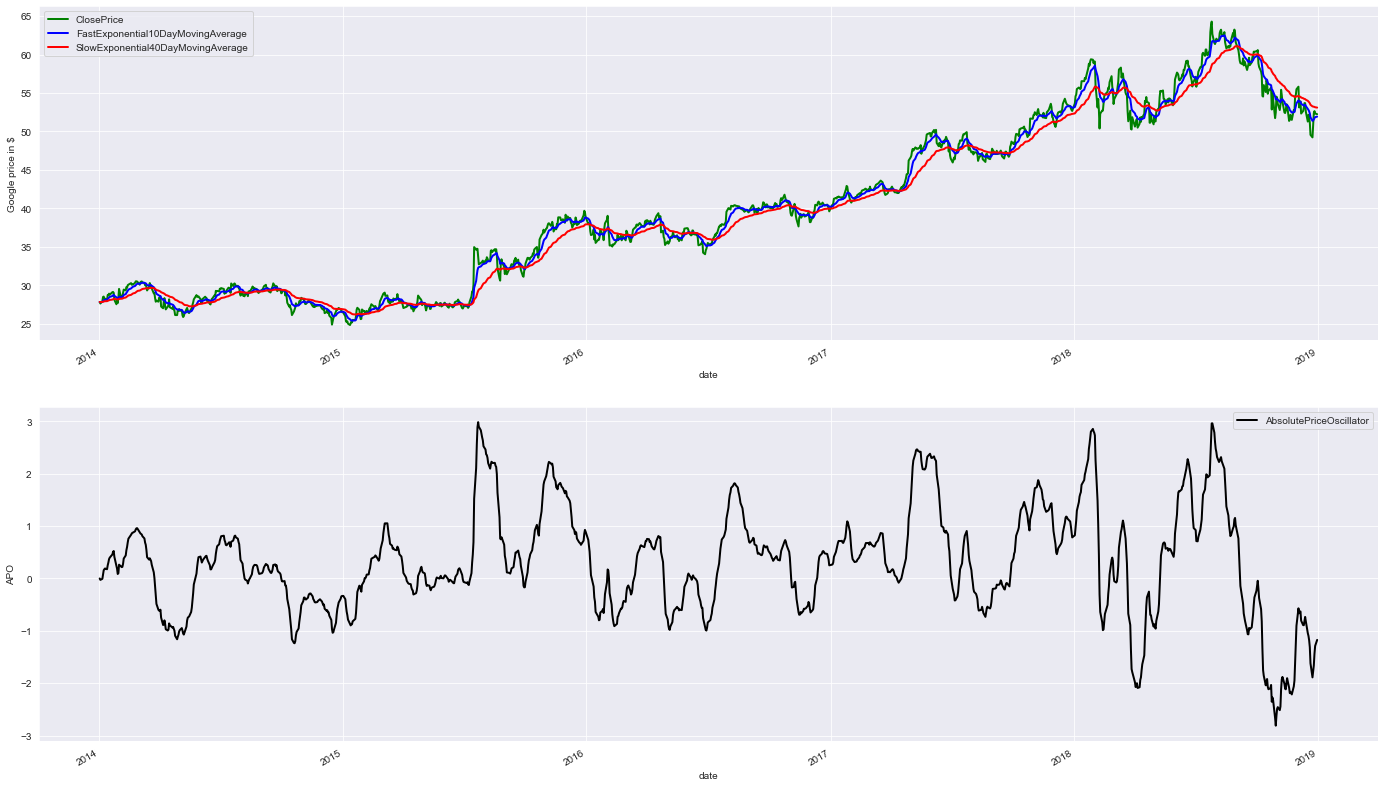

In [5]:
fig = plt.figure(figsize=(24, 15))
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='APO')
apo.plot(ax=ax2, color='black', lw=2., legend=True)
plt.show()

# Task 4 - Build model with the MACD indicator

## This code segment implements a moving average convergence divergence signal with a fast EMA period of 10 days, a slow EMA period of 40 days, and with default smoothing factors of 2/11 and 2/41, respectively.

In [6]:
close = goog_data['closeadj']
K_fast = 2 / (EMA_WINDOW_FAST + 1) # fast EMA smoothing factor
ema_fast = 0
K_slow = 2 / (EMA_WINDOW_SLOW + 1) # slow EMA smoothing factor
ema_slow = 0
K_macd = 2 / (EMA_WINDOW_MACD + 1) # MACD EMA smoothing factor
ema_macd = 0

ema_fast_values = [] # track fast EMA values for visualization purposes
ema_slow_values = [] # track slow EMA values for visualization purposes
macd_values = [] # track MACD values for visualization purposes
macd_signal_values = [] # MACD EMA values tracker
macd_historgram_values = [] # MACD - MACD-EMA
for close_price in close:
  if ema_fast == 0: # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_fast + ema_fast
    ema_slow = (close_price - ema_slow) * K_slow + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  macd = ema_fast - ema_slow # MACD is fast_MA - slow_EMA
  if ema_macd == 0:
    ema_macd = macd
  else:
    ema_macd = (macd - ema_macd) * K_macd + ema_macd # signal is EMA of MACD values

  macd_values.append(macd)
  macd_signal_values.append(ema_macd)
  macd_historgram_values.append(macd - ema_macd)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(MovingAverageConvergenceDivergence=pd.Series(macd_values, index=goog_data.index))
goog_data = goog_data.assign(Exponential20DayMovingAverageOfMACD=pd.Series(macd_signal_values, index=goog_data.index))
goog_data = goog_data.assign(MACDHistorgram=pd.Series(macd_historgram_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
macd = goog_data['MovingAverageConvergenceDivergence']
ema_macd = goog_data['Exponential20DayMovingAverageOfMACD']
macd_histogram = goog_data['MACDHistorgram']
print(ema_macd.head())

date
2014-01-02    0.000000
2014-01-03   -0.027007
2014-01-06   -0.025083
2014-01-07   -0.015011
2014-01-08    0.001266
Name: Exponential20DayMovingAverageOfMACD, dtype: float64


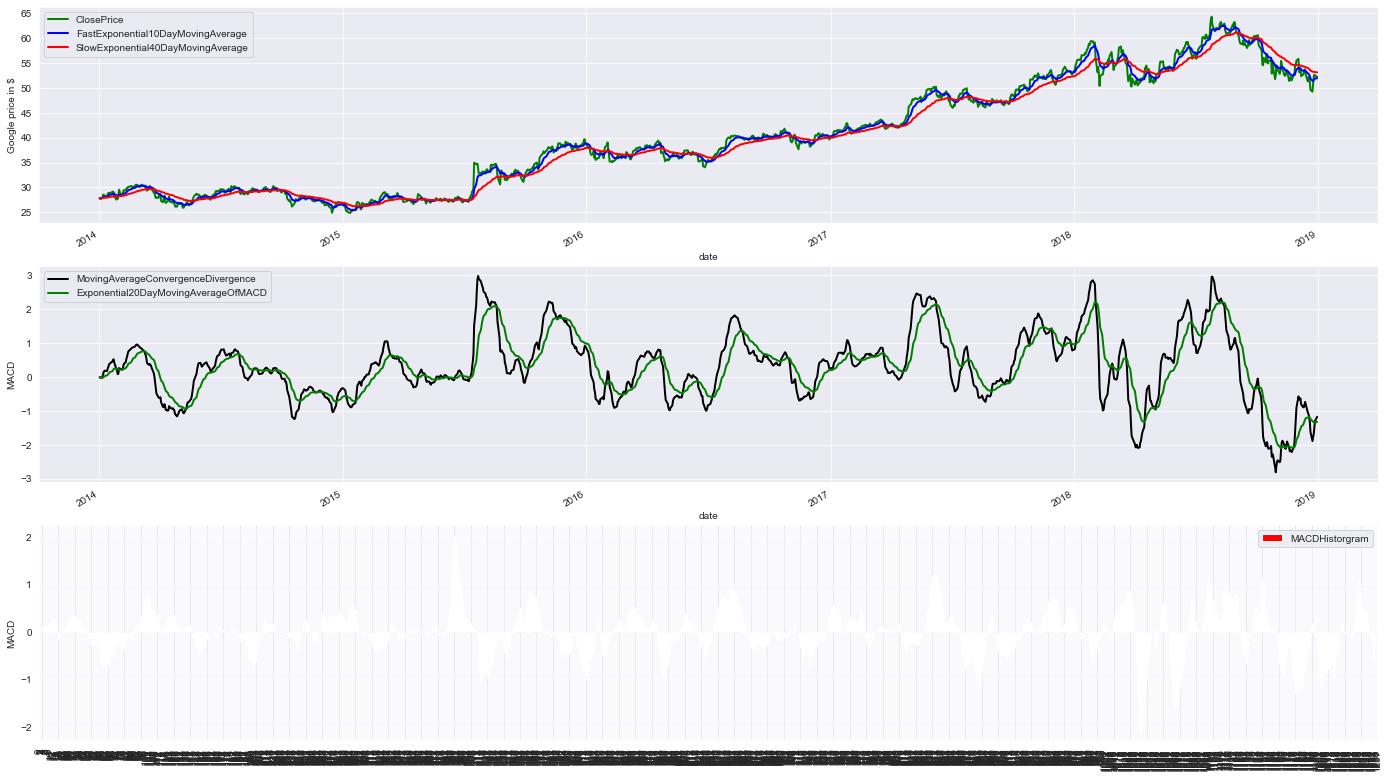

In [7]:
fig = plt.figure(figsize=(24, 15))
ax1 = fig.add_subplot(311, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(312, ylabel='MACD')
macd.plot(ax=ax2, color='black', lw=2., legend=True)
ema_macd.plot(ax=ax2, color='g', lw=2., legend=True)
ax3 = fig.add_subplot(313, ylabel='MACD')
macd_histogram.plot(ax=ax3, color='r', kind='bar', legend=True, use_index=False)
plt.show()